In [1]:
import os
import pandas as pd
import numpy as np
import datetime

from matplotlib import pyplot as plt
%matplotlib inline

## Fetching the entire series of historic oilspot prices.

In [2]:
op_raw = pd.read_csv('sql_output//Dim_Oilspot.csv', index_col='day', parse_dates=True, usecols=['day', 'price'])

In [3]:
op_raw.head()

,price
day,
2017-04-06,53.62
2017-04-07,54.24
2017-04-10,54.79
2017-04-11,54.73
2017-04-12,54.75


In [4]:
op = op_raw.copy()

In [5]:
first_day = op.index[0]
last_day = op.index[-1]
complete_date_range = pd.date_range(start=first_day, end=last_day, freq='D')
temp = pd.DataFrame(index=complete_date_range)

op = op.merge(temp, how='right', left_index=True, right_index=True)

In [6]:
op = op.replace('.', np.nan).astype('float32')

c:\users\arild\appdata\local\programs\python\python37-32\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


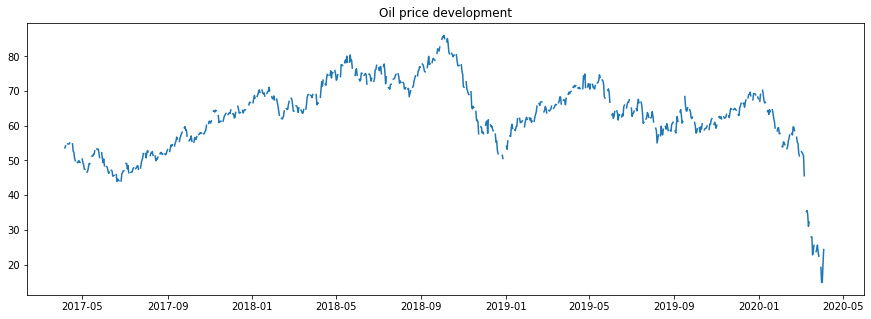

In [7]:
fig, ax = plt.subplots(1, figsize=(15,5))
ax.plot(op)
ax.set_title('Oil price development')
plt.show()

In [8]:
op.isna().sum()

price    331
dtype: int64

In [9]:
round( len(op) / 7 * 2 )

313

So the weekends pretty much account for all our missing oil price values.

Hence, it can be considered a decent solution to *first* frontfill the missing values (let weekends inherit Friday's price) and then backfill (let the missing values at the start of the timeseries inherit next valid day)

In [10]:
op_filled = op.fillna(method='ffill')
op_filled = op_filled.fillna(method='bfill')

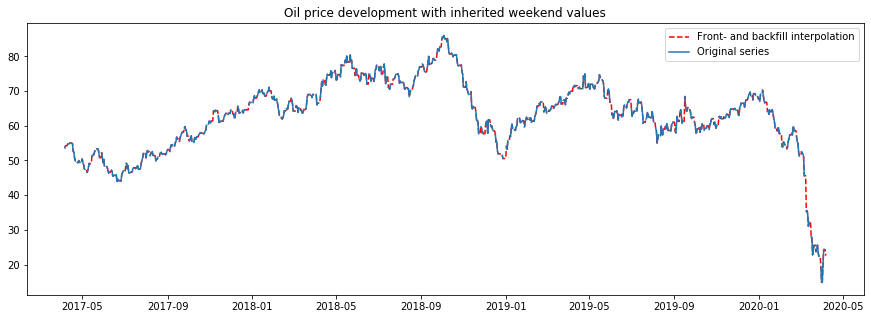

In [11]:
fig, ax = plt.subplots(1, figsize=(15,5))

ax.plot(op_filled, '--', c='r', label='Front- and backfill interpolation')
ax.plot(op, label='Original series')
ax.legend()
ax.set_title('Oil price development with inherited weekend values')
plt.show()

In [12]:
op_filled.isna().sum()

price    0
dtype: int64

In [13]:
op_filled.to_csv('cleansed_data//Oilspot_prices.csv')

## Moving on to Elspot prices

In [14]:
ep_raw = pd.read_csv('sql_output//Dim_Elspot.csv', index_col='time', parse_dates=True, 
                     usecols=['time', 'price'], dtype='float32')

In [15]:
ep_raw.head()

,price
time,
2018-01-01 00:00:00,26.330000
2018-01-01 01:00:00,26.430000
2018-01-01 02:00:00,26.100000
2018-01-01 03:00:00,24.700001
2018-01-01 04:00:00,24.740000


In [16]:
ep = ep_raw.copy()

In [17]:
first_day = ep.index[0]
last_day = ep.index[-1]
complete_date_range = pd.date_range(start=first_day, end=last_day, freq='H')
temp = pd.DataFrame(index=complete_date_range)

ep = ep.merge(temp, how='right', left_index=True, right_index=True)

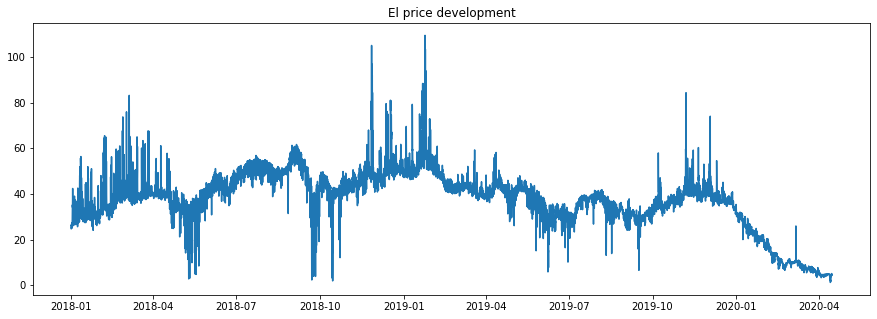

In [18]:
fig, ax = plt.subplots(1, figsize=(15,5))
ax.plot(ep)
ax.set_title('El price development')
plt.show()

In [19]:
ep.isna().sum()

price    3
dtype: int64

So we only have 3 missing values. Where are they?

In [20]:
ep.iloc[np.where(ep['price'].isna())]

,price
2018-03-25 02:00:00,NaN
2019-03-31 02:00:00,NaN
2020-03-29 02:00:00,NaN


Quite spread (although peculiar that they occur with one year apart. Maintenence maybe?). We'll do a linear interpolation for those.

In [21]:
ep['price'] = ep['price'].interpolate(method='linear')

In [22]:
ep.isna().sum()

price    0
dtype: int64

In [23]:
ep.to_csv('cleansed_data//Elspot_prices.csv')

## Onto the weather!

In [24]:
wdf_raw = pd.read_csv('sql_output//Dim_Weather.csv', index_col='time', parse_dates=True,
                     usecols=['time', 'weather_station', 'temperature'], 
                      dtype={'weather_station':'str', 'temperature':'float32'})

In [25]:
wdf_raw.head()

,weather_station,temperature
time,,
2018-01-01,SN35210,-0.3
2018-01-01,SN36200,6.9
2018-01-01,SN36330,4.1
2018-01-01,SN38140,5.5
2018-01-01,SN39040,5.6


In [26]:
wdf = wdf_raw.copy()

Here we need to separate on `weather_station` and do each separately

In [27]:
stations = wdf['weather_station'].unique()

In [28]:
subset = wdf[wdf['weather_station'] == stations[0]]

In [29]:
first_day = subset.index[0]
last_day = subset.index[-1]
complete_date_range = pd.date_range(start=first_day, end=last_day, freq='H')
temp = pd.DataFrame(index=complete_date_range)

subset = subset.merge(temp, how='right', left_index=True, right_index=True)

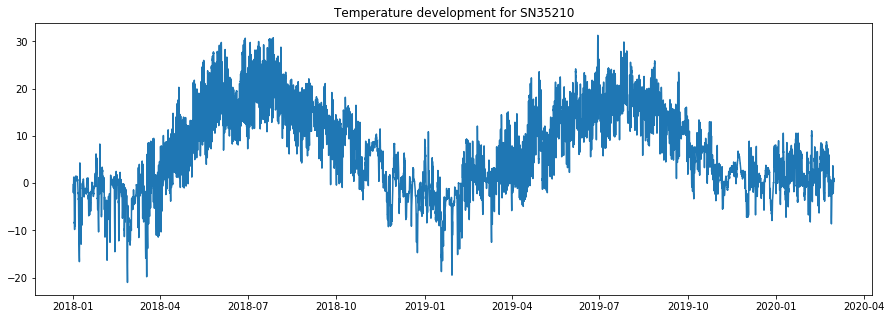

In [30]:
fig, ax = plt.subplots(1, figsize=(15,5))
ax.plot(subset['temperature'])
ax.set_title(f'Temperature development for {stations[0]}')
plt.show()

In [31]:
subset.isna().sum()

weather_station    0
temperature        0
dtype: int64

Quite nice data there! Big thanks to [Frost API](https://frost.met.no/index.html)! Let's see how the other series are:

In [32]:
d = {}

for st in stations:
    subset = wdf[wdf['weather_station'] == st]   
    first_day = subset.index[0]
    last_day = subset.index[-1]
    complete_date_range = pd.date_range(start=first_day, end=last_day, freq='H')
    temp = pd.DataFrame(index=complete_date_range)

    subset = subset.merge(temp, how='right', left_index=True, right_index=True)
    
    d[st] = subset

In [33]:
for st, sub in d.items():
    print(f'Station: {st}, NaNs: {sub.temperature.isna().sum()}')

Station: SN35210, NaNs: 0
Station: SN36200, NaNs: 48
Station: SN36330, NaNs: 415
Station: SN38140, NaNs: 0
Station: SN39040, NaNs: 37
Station: SN39750, NaNs: 0
Station: SN40880, NaNs: 2798
Station: SN41090, NaNs: 0
Station: SN41770, NaNs: 39
Station: SN41825, NaNs: 0
Station: SN42940, NaNs: 0


Six stations are perfect, 3 have a few holes and two seem to be more lossy.

Saving the six that are perfect as is.

In [34]:
cleansed_wdf = pd.DataFrame(columns=wdf.columns)
lossy_stations = {}
for st, sub in d.items():
    if not sub['temperature'].isna().sum(): cleansed_wdf = cleansed_wdf.append(sub)
    else: lossy_stations[st] = sub.copy()

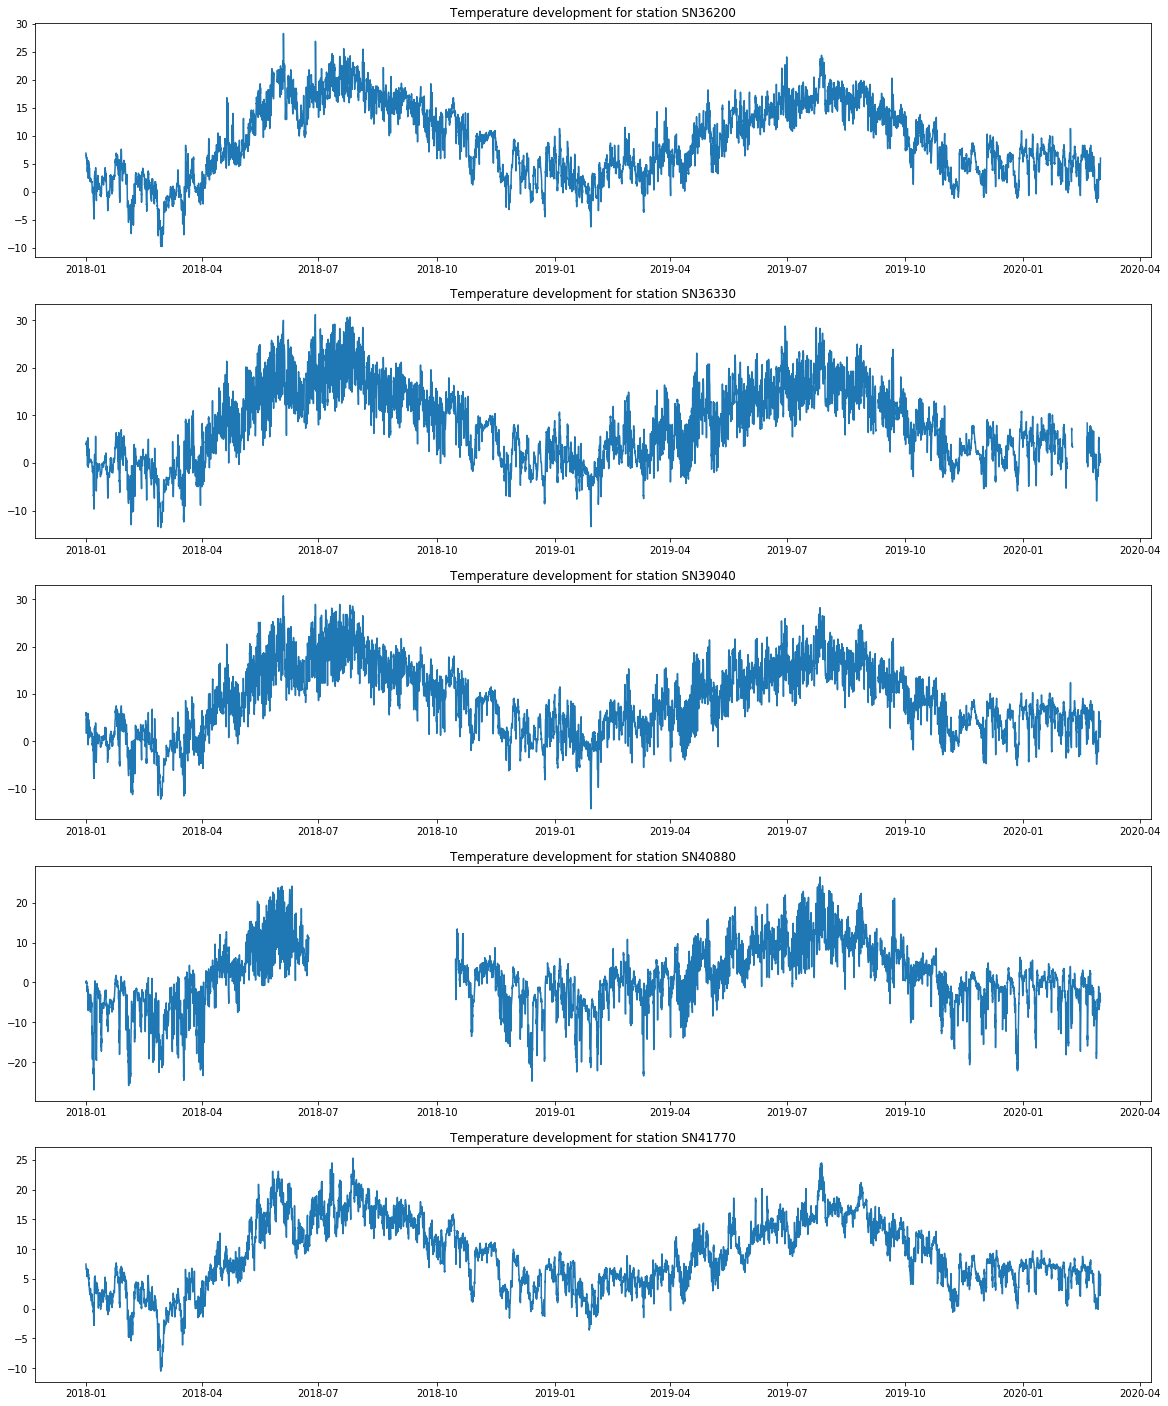

In [35]:
n = len(lossy_stations)
fig, ax = plt.subplots(n, 1, figsize=(20, n*5))

for i, (k,v) in enumerate(lossy_stations.items()):
    ax[i].plot(v.temperature)
    ax[i].set_title(f'Temperature development for station {k}')
plt.show()

**A few remarks**
 * From the top, only the second and the fourth timeseries suffers from large holes.
 * All measurements are from the same county.

How good is an estimation based on:
 * The mean temperature in the other time series at that time.
 * The median temperature in the other time series at that time.
 * Z-transform all measurements based on their respective timeseries characteristics.

Selecting a snippet from the fourth timeseries to compare the methods, using its own measurement as ground truth.

In [36]:
subset = d['SN40880']
date_range = pd.date_range(start='2019-01-01 00:00', end='2019-07-01 00:00', freq='H')

In [37]:
subset.loc[date_range].isna().sum()

weather_station    0
temperature        0
dtype: int64

Great! There's six months without NaNs. This is our ground truth.

In [38]:
subset_mean = np.nanmean(subset['temperature'])
subset_std = np.nanstd(subset['temperature'])

In [39]:
others = d.copy()
del others[subset.iloc[0]['weather_station']]

In [40]:
stds = [np.nanstd(o['temperature']) for _, o in others.items()]
means = [np.nanmean(o['temperature']) for _, o in others.items()]

median_temps_transformed = [np.nanmedian([(sub.loc[date]['temperature']-m)/s for (_, sub), m, s in zip(others.items(), means, stds)]) for date in date_range]
mean_temps_transformed = [np.nanmean([(sub.loc[date]['temperature']-m)/s for (_, sub), m, s in zip(others.items(), means, stds)]) for date in date_range]

In [41]:
median_temps_detransformed = [v*subset_std + subset_mean for v in  median_temps_transformed]
mean_temps_detransformed = [v*subset_std + subset_mean for v in  mean_temps_transformed]

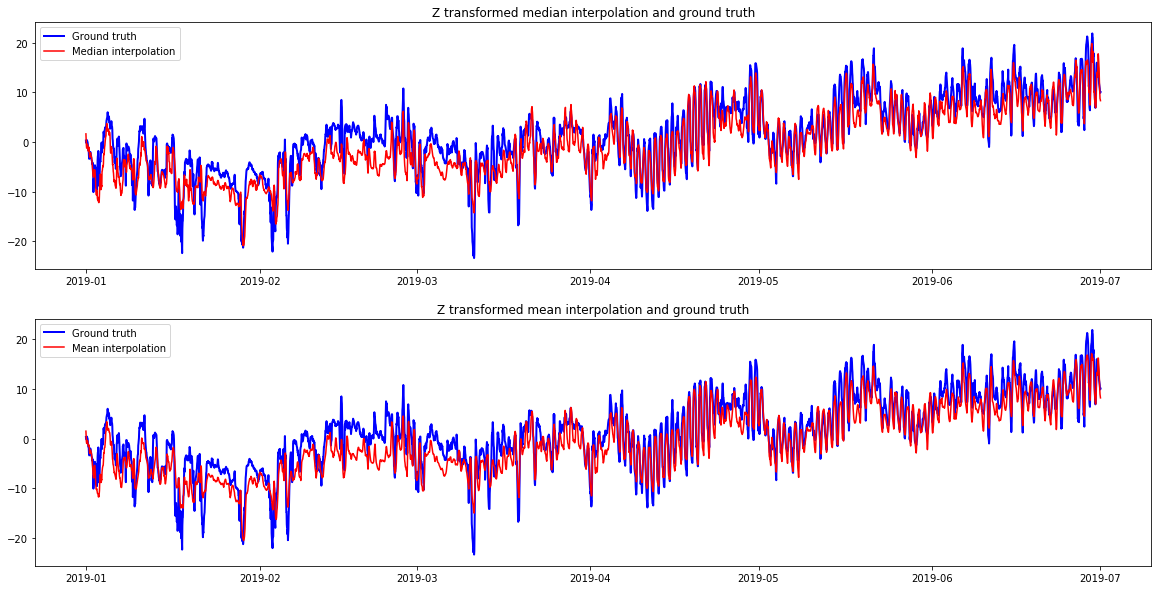

In [42]:
fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(subset.loc[date_range]['temperature'], c='b', lw=2, label='Ground truth')
ax[0].plot(date_range, median_temps_detransformed, c='r', label='Median interpolation')
ax[0].set_title('Z transformed median interpolation and ground truth')
ax[0].legend()

ax[1].plot(subset.loc[date_range]['temperature'], c='b', lw=2, label='Ground truth')
ax[1].plot(date_range, mean_temps_detransformed, c='r', label='Mean interpolation')
ax[1].set_title('Z transformed mean interpolation and ground truth')
ax[1].legend()
plt.show()

In [43]:
from sklearn.metrics import mean_squared_error

In [44]:
mse_median = mean_squared_error(median_temps_detransformed, subset.loc[date_range]['temperature'])
mse_mean = mean_squared_error(mean_temps_detransformed, subset.loc[date_range]['temperature'])

print(f'Median mse: {mse_median:.2f}')
print(f'Mean mse: {mse_mean:.2f}')

Median mse: 10.21
Mean mse: 10.00


What if we only picked the timeseries that was closest to the characteristics of our reference?

In [45]:
devs = []

for m, s in zip(means, stds): devs.append((m-subset_mean)**2 + (s-subset_std)**2)
    
idx = np.where(devs==min(devs))

for i, (k, other), in enumerate(others.items()): 
    if i==idx: break

best_fit_transformed = (other.loc[date_range]['temperature']-means[idx[0][0]])/stds[idx[0][0]]
best_fit = other.loc[date_range]['temperature']

In [46]:
best_fit_detransformed = [v*subset_std+subset_mean for v in best_fit_transformed]

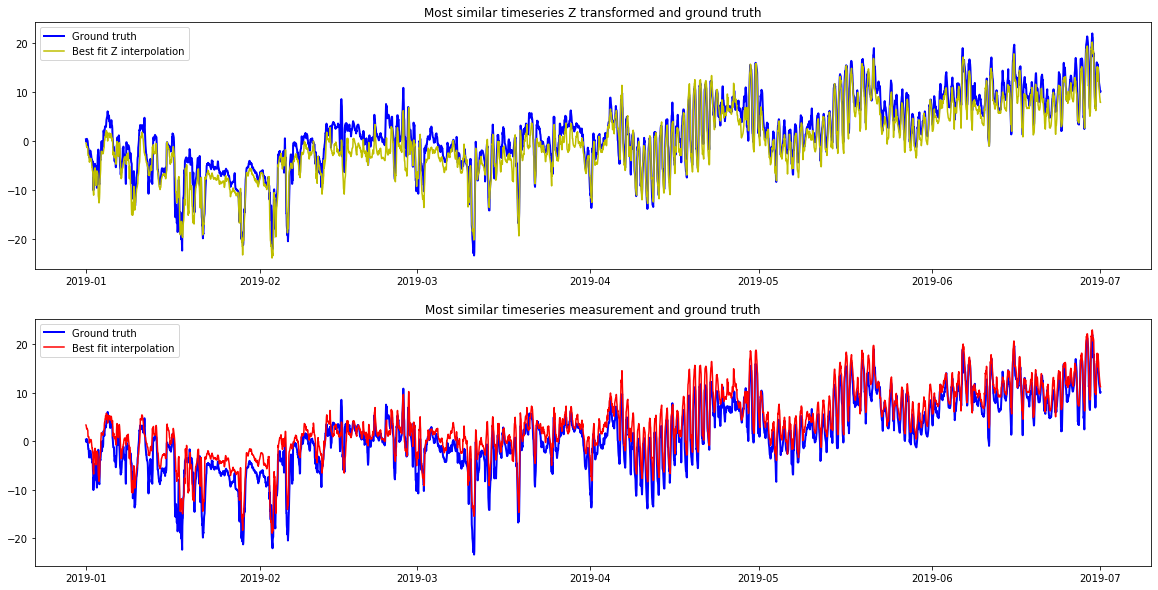

In [47]:
fig, ax = plt.subplots(2,1, figsize=(20,10))

ax[0].plot(subset.loc[date_range]['temperature'], c='b', lw=2, label='Ground truth')
ax[0].plot(date_range, best_fit_detransformed, c='y', label='Best fit Z interpolation')
ax[0].set_title('Most similar timeseries Z transformed and ground truth')

ax[1].plot(subset.loc[date_range]['temperature'], c='b', lw=2, label='Ground truth')
ax[1].plot(date_range, best_fit, c='r', label='Best fit interpolation')
ax[1].set_title('Most similar timeseries measurement and ground truth')

ax[0].legend()
ax[1].legend()
plt.show()

In [48]:
mse_best_fit_Z = mean_squared_error(best_fit_detransformed, subset.loc[date_range]['temperature'])
mse_best_fit = mean_squared_error(best_fit, subset.loc[date_range]['temperature'])

print(f'Best fit Z transformed mse: {mse_best_fit_Z:.2f}')
print(f'Best fit mse: {mse_best_fit:.2f}')

Best fit Z transformed mse: 6.92
Best fit mse: 8.29


Text(0.5, 1.0, 'Most similar timeseries Z transformed and ground truth')

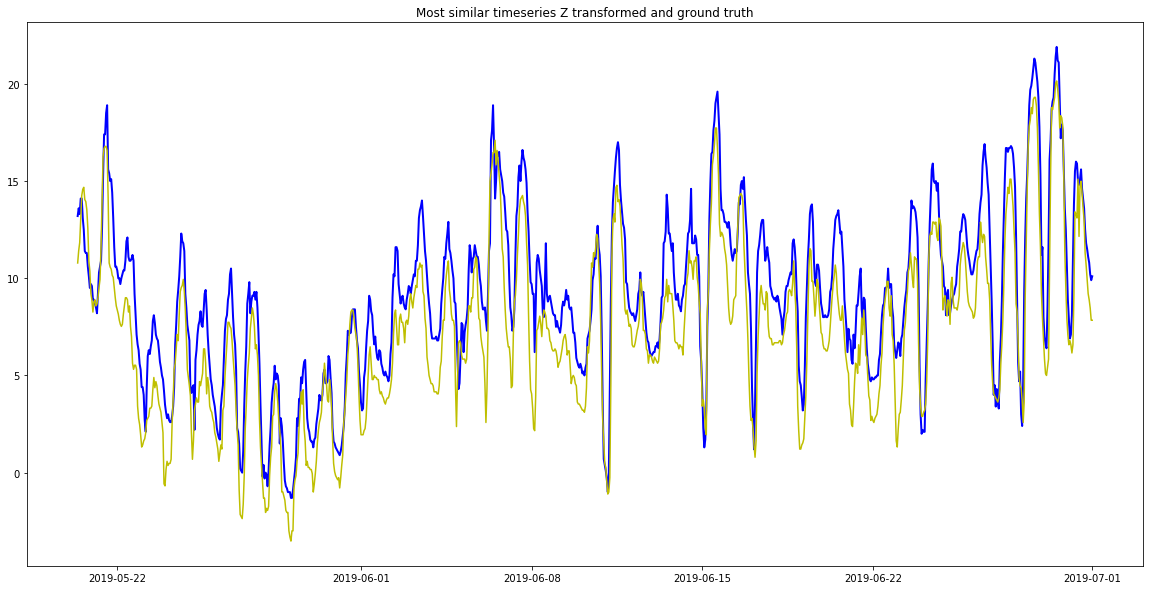

In [52]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(subset.loc[date_range[-1000:]]['temperature'], c='b', lw=2, label='Ground truth')
ax.plot(date_range[-1000:], best_fit_detransformed[-1000:], c='y', label='Best fit Z interpolation')
ax.set_title('Most similar timeseries Z transformed and ground truth')


That settles it. Picking the value from the most similar timeseries seems to be a nice way to stipulate the missing values in this timeseries.

Selecting one close timeseries for each timeseries with missing values (which hopefully does not have holes in the same place)

In [51]:
stipulated_lossies = {}

for st, sub in lossy_stations.items():
    
    others = d.copy()
    del others[st]
    
    nan_indices = sub.iloc[np.where(sub['temperature'].isna())].index
    
    sub_mean = np.nanmean(sub['temperature'])
    sub_std = np.nanstd(sub['temperature'])
    
    stds = [np.nanstd(o['temperature']) for _, o in others.items()]
    means = [np.nanmean(o['temperature']) for _, o in others.items()]
    
    devs = []

    for m, s in zip(means, stds): devs.append((m-sub_mean)**2 + (s-sub_std)**2)

    idx = np.where(devs==min(devs))

    for i, (k, other), in enumerate(others.items()): 
        if i==idx: break

    best_fit_transformed = (other.loc[nan_indices]['temperature']-means[idx[0][0]])/stds[idx[0][0]]
    best_fit_detransformed = [v*sub_std+sub_mean for v in best_fit_transformed]    
    
    temp = pd.DataFrame(index=nan_indices, 
                        data={'weather_station':st, 'temperature':best_fit_detransformed})
    
    sub.update(temp)
    
    stipulated_lossies[st] = sub

In [52]:
for k, v in stipulated_lossies.items():
    print(f'Station: {k}, missing values: {v.temperature.isna().sum()}')

Station: SN36200, missing values: 0
Station: SN36330, missing values: 0
Station: SN39040, missing values: 0
Station: SN40880, missing values: 0
Station: SN41770, missing values: 0


Nice! Adding these to the cleansed dataframe

In [53]:
for _, v in stipulated_lossies.items(): cleansed_wdf = cleansed_wdf.append(v)

In [54]:
len(cleansed_wdf)

208560

In [55]:
len(wdf_raw)

205223

In [56]:
cleansed_wdf.to_csv('cleansed_data//Weather.csv')

## Lastly, fix consumption losses

In [53]:
cons_raw = pd.read_csv('sql_output//Dim_Belastning_and_weather_station.csv', index_col='time', parse_dates=True,
                     usecols=['time', 'loc_id', 'weather_station', 'consumption_kvah'], 
                     dtype={'loc_id':'str', 'weather_station':'str', 'consumption_kvah':'float32'})

In [54]:
cons_raw.head()

,loc_id,weather_station,consumption_kvah
time,,,
2018-01-01,0,SN38140,27.0
2018-01-01,1,SN36200,150.0
2018-01-01,3,SN39750,18.5
2018-01-01,4,SN40880,120.0
2018-01-01,6,SN36330,35.0


In [55]:
cons = cons_raw.copy()

In [56]:
# Same approach as for weather. 
# Separate the timeseries for the different loc_ids and analyze their missing values

locs = cons['loc_id'].unique()

d = {}

for loc in locs:
    
    subset = cons[cons['loc_id'] == loc]   
    first_day = subset.index[0]
    last_day = subset.index[-1]
    complete_date_range = pd.date_range(start=first_day, end=last_day, freq='H')
    temp = pd.DataFrame(index=complete_date_range)

    subset = subset.merge(temp, how='right', left_index=True, right_index=True)
    
    d[loc] = subset

In [57]:
for loc, sub in d.items():
    print(f'Location: {loc}, NaNs: {sub.consumption_kvah.isna().sum()}')

Location: 0, NaNs: 28
Location: 1, NaNs: 103
Location: 3, NaNs: 128
Location: 4, NaNs: 56
Location: 6, NaNs: 126
Location: 10, NaNs: 28
Location: 11, NaNs: 52
Location: 12, NaNs: 148
Location: 16, NaNs: 100
Location: 17, NaNs: 148
Location: 18, NaNs: 28
Location: 19, NaNs: 124
Location: 7, NaNs: 52
Location: 8, NaNs: 51
Location: 14, NaNs: 3
Location: 2, NaNs: 51
Location: 5, NaNs: 51
Location: 15, NaNs: 99
Location: 13, NaNs: 6199
Location: 9, NaNs: 51


Most are moderate here, except number 13. Unlucky. Let's have a look at that one.

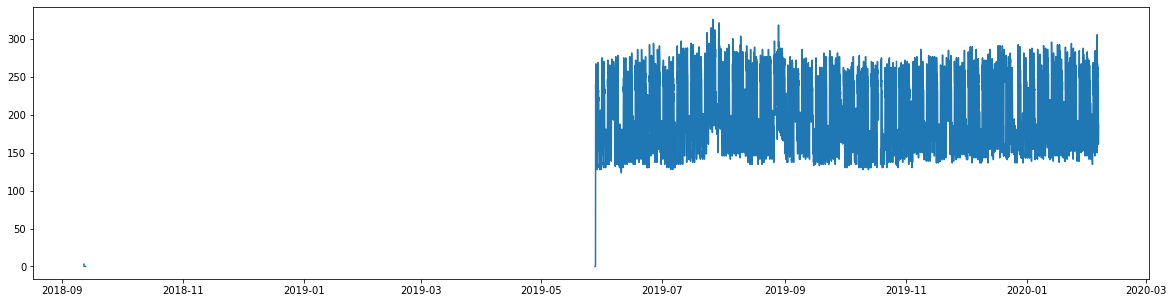

In [58]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(d['13']['consumption_kvah'])
plt.show()

Recall the sample sql query where number 13 was the series with the lowest mean consumption? Here's why.

Obviously we need a new criteria: All zeros are considered missing data. Let's exlude super-outliers as well, say all records $\notin \mu \pm 4  \sigma$.

In [59]:
for loc in locs:
    
    subset = cons[cons['loc_id'] == loc]
    
    subset = subset.drop(subset.index[np.where(subset['consumption_kvah']==0)], axis=0)  
    
    m = np.nanmean(subset['consumption_kvah'])
    s = np.nanstd(subset['consumption_kvah'])
    
    upper_quantile = m + 4*s
    lower_quantile = m - 4*s
    
    mask_1 = subset['consumption_kvah'] < lower_quantile
    mask_2 = subset['consumption_kvah'] > upper_quantile
    
    subset = subset.drop(subset[mask_1|mask_2].index, axis=0)
    
    first_day = subset.index[0]
    last_day = subset.index[-1]
    complete_date_range = pd.date_range(start=first_day, end=last_day, freq='H')
    temp = pd.DataFrame(index=complete_date_range)

    subset = subset.merge(temp, how='right', left_index=True, right_index=True)
    
    d[loc] = subset

In [60]:
for loc, sub in d.items():
    print(f'Location: {loc}, NaNs: {sub.consumption_kvah.isna().sum()}')

Location: 0, NaNs: 28
Location: 1, NaNs: 110
Location: 3, NaNs: 148
Location: 4, NaNs: 77
Location: 6, NaNs: 143
Location: 10, NaNs: 66
Location: 11, NaNs: 93
Location: 12, NaNs: 153
Location: 16, NaNs: 171
Location: 17, NaNs: 171
Location: 18, NaNs: 28
Location: 19, NaNs: 129
Location: 7, NaNs: 112
Location: 8, NaNs: 253
Location: 14, NaNs: 37
Location: 2, NaNs: 62
Location: 5, NaNs: 76
Location: 15, NaNs: 135
Location: 13, NaNs: 31
Location: 9, NaNs: 59


That brushed up some things!

**Although** the super extremes are now gone. Some of them were definitely true. Like transformer overloads and such. However, this analysis revolves around mining of typical patterns, not prediction of extremes.

Most stipulations on consumption timeseries like these are based on using last week's value at the specific time instance. Let's compare a few approaches:

In [61]:
date_range = pd.date_range(start='2018-06-01 00:00', end='2018-10-01 00:00', freq='H')
subset = d['0'].loc[date_range]['consumption_kvah']

In [62]:
subset.isna().sum()

0

That's four months without NaNs!

Using these measurements as ground truth

In [63]:
last_week = d['0']['consumption_kvah'].shift(7*24).loc[date_range]

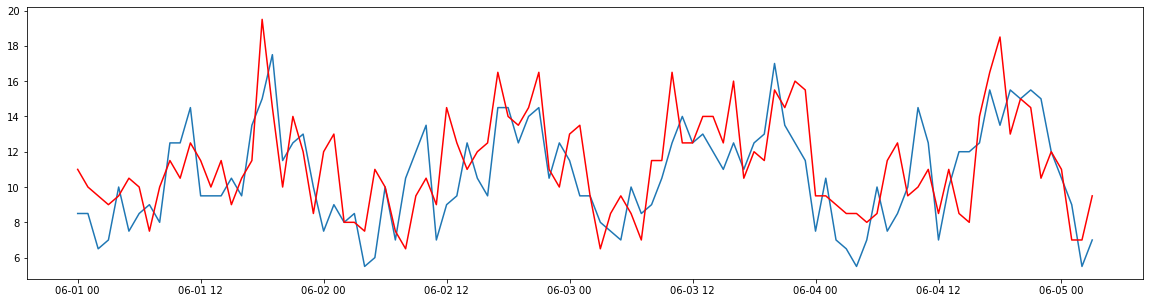

In [64]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(subset[:100])
ax.plot(last_week[:100], c='r')
plt.show()

In [65]:
mse_last_week = mean_squared_error(subset, last_week)
print(f'mse last week: {mse_last_week:.2f}')

mse last week: 8.70


Safe to say this is suboptimal, but somewhat useful. Lets say we only have missing values with two true value neighbours. How well does linear interpolation do?

In [66]:
every_other_day = [v for i, v in enumerate(date_range) if not i%2]
every_other_value = subset.loc[every_other_day].to_frame().merge(pd.DataFrame(index=date_range), 
                                                                 how='right', left_index=True, 
                                                                 right_index=True)
every_other_interpolated = every_other_value.interpolate(how='linear')

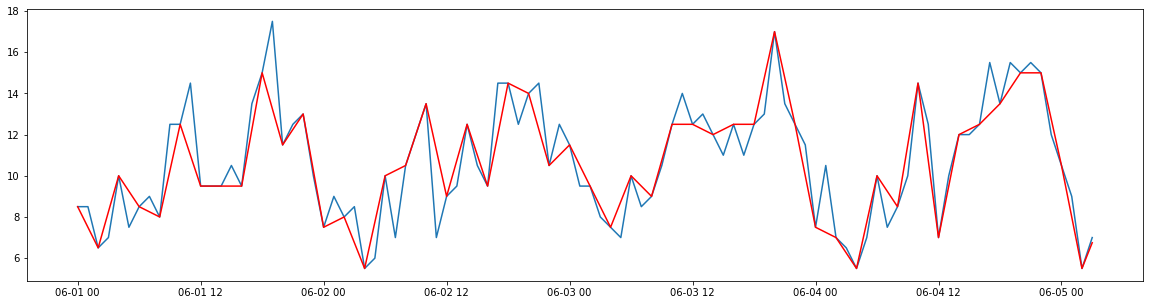

In [67]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(subset[:100])
ax.plot(every_other_interpolated[:100], c='r')
plt.show()

In [68]:
mse_interpolation = mean_squared_error(subset, every_other_interpolated)
print(f'mse every other day interpolation: {mse_interpolation:.2f}')

mse every other day interpolation: 1.94


Cool! How about interpolating two days in a row?

In [69]:
one_of_three_days = [v for i, v in enumerate(date_range) if not i%3]
one_of_three_values = subset.loc[one_of_three_days].to_frame().merge(pd.DataFrame(index=date_range), 
                                                                 how='right', left_index=True, 
                                                                 right_index=True)
one_of_three_interpolated = one_of_three_values.interpolate(how='linear')

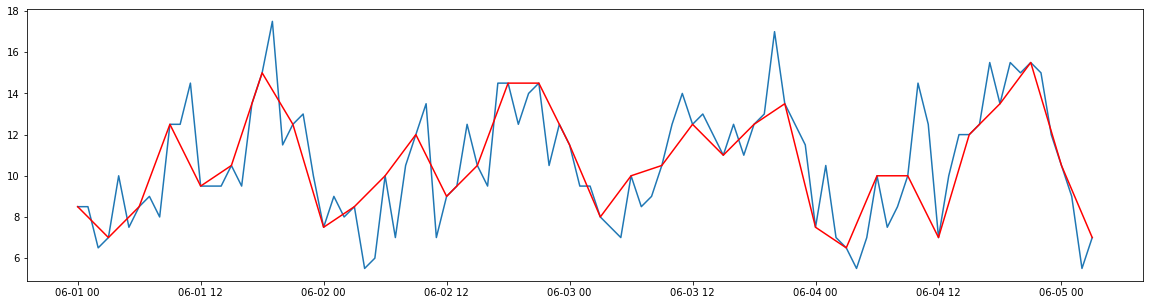

In [70]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
ax.plot(subset[:100])
ax.plot(one_of_three_interpolated[:100], c='r')
plt.show()

In [71]:
mse_one_of_three = mean_squared_error(subset, one_of_three_interpolated)
print(f'mse one of three interpolation: {mse_one_of_three:.2f}')

mse one of three interpolation: 3.23


Starting to lose track of sudden shifts here.

Choosing linear interpolation where there are one or two missing values in a row, and last week (or next week) interpolation for the rest.

In [74]:
cleansed_cons = {}
for loc, sub in d.items():
    c = sub.copy()

    c['loc_id'] = loc
    
    c['weather_station'] = c['weather_station'].fillna(method='ffill')
    c['weather_station'] = c['weather_station'].fillna(method='bfill')
    
    c['consumption_kvah'] = c['consumption_kvah'].interpolate(method='linear', limit=2)
    
    last_week = c['consumption_kvah'].shift(7*24)
    next_week = c['consumption_kvah'].shift(-7*24)
    
    c.update(last_week, overwrite=False)
    c.update(next_week, overwrite=False)
    
    cleansed_cons[loc] = c


In [75]:
for k, v in cleansed_cons.items():
    print(f'Remaining NaNs in {k}: {v.consumption_kvah.isna().sum()}')

Remaining NaNs in 0: 0


Checking out a hole in the last timeseries to verify that we're on the right track

In [76]:
sub.iloc[np.where(sub['consumption_kvah'].isna())].head(50)

,loc_id,weather_station,consumption_kvah
2018-03-25 02:00:00,NaN,NaN,NaN
2018-10-28 03:00:00,NaN,NaN,NaN
2019-03-31 02:00:00,NaN,NaN,NaN
2019-05-17 01:00:00,NaN,NaN,NaN
2019-05-17 02:00:00,NaN,NaN,NaN
2019-05-17 03:00:00,NaN,NaN,NaN
2019-05-17 04:00:00,NaN,NaN,NaN
2019-05-17 05:00:00,NaN,NaN,NaN
2019-05-17 06:00:00,NaN,NaN,NaN
2019-05-17 07:00:00,NaN,NaN,NaN


Not easy to tell what's a good stipolation here, but it looks allright.

Gather up the cleansed data.

In [80]:
cleansed_cons_df = pd.DataFrame(columns=cons.columns)
for _, df in cleansed_cons.items(): cleansed_cons_df = cleansed_cons_df.append(df)

In [81]:
cleansed_cons_df.shape

(329875, 3)

In [82]:
cleansed_cons_df.to_csv('cleansed_data//Consumption.csv')

## Join all where there exists consumption

In [157]:
cleansed_cons_df['time'] = cleansed_cons_df.index
cleansed_cons_df['day'] = cleansed_cons_df.index.date
cleansed_wdf['time'] = cleansed_wdf.index
ep['time'] = ep.index
op_filled['day'] = op_filled.index.date

In [162]:
all_data = cleansed_cons_df.merge(cleansed_wdf, how='left', left_on=['time', 'weather_station'], right_on=['time', 'weather_station'])
all_data = all_data.merge(ep, how='left', left_on='time', right_on='time')
all_data = all_data.rename({'price':'el_price'}, axis=1)
all_data = all_data.merge(op_filled, how='left', left_on='day', right_on='day')
all_data = all_data.rename({'price':'oil_price'}, axis=1)
all_data = all_data.set_index('time')
all_data = all_data.drop(['weather_station', 'day'], axis=1)

In [163]:
all_data.head()

,loc_id,consumption_kvah,temperature,el_price,oil_price
time,,,,,
2018-01-01 00:00:00,0,27.0,5.5,26.330000,66.730003
2018-01-01 01:00:00,0,27.5,5.0,26.430000,66.730003
2018-01-01 02:00:00,0,27.0,4.8,26.100000,66.730003
2018-01-01 03:00:00,0,23.0,4.9,24.700001,66.730003
2018-01-01 04:00:00,0,23.0,3.7,24.740000,66.730003


In [164]:
all_data.shape

(329875, 5)

In [165]:
all_data.to_csv('cleansed_data//all_consumption_metadata.csv')

In [166]:
all_data.isna().sum()

loc_id              0
consumption_kvah    0
temperature         0
el_price            0
oil_price           0
dtype: int64

In [ ]:
S